In [1]:
# 2D Toy training example
# using classical linear neurons for comparison with other exps

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# graph viz tool
# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
torch.manual_seed(173)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000

samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
# (labels are one-hot)
samples_labels = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs, sep_plane)])

<IPython.core.display.Javascript object>


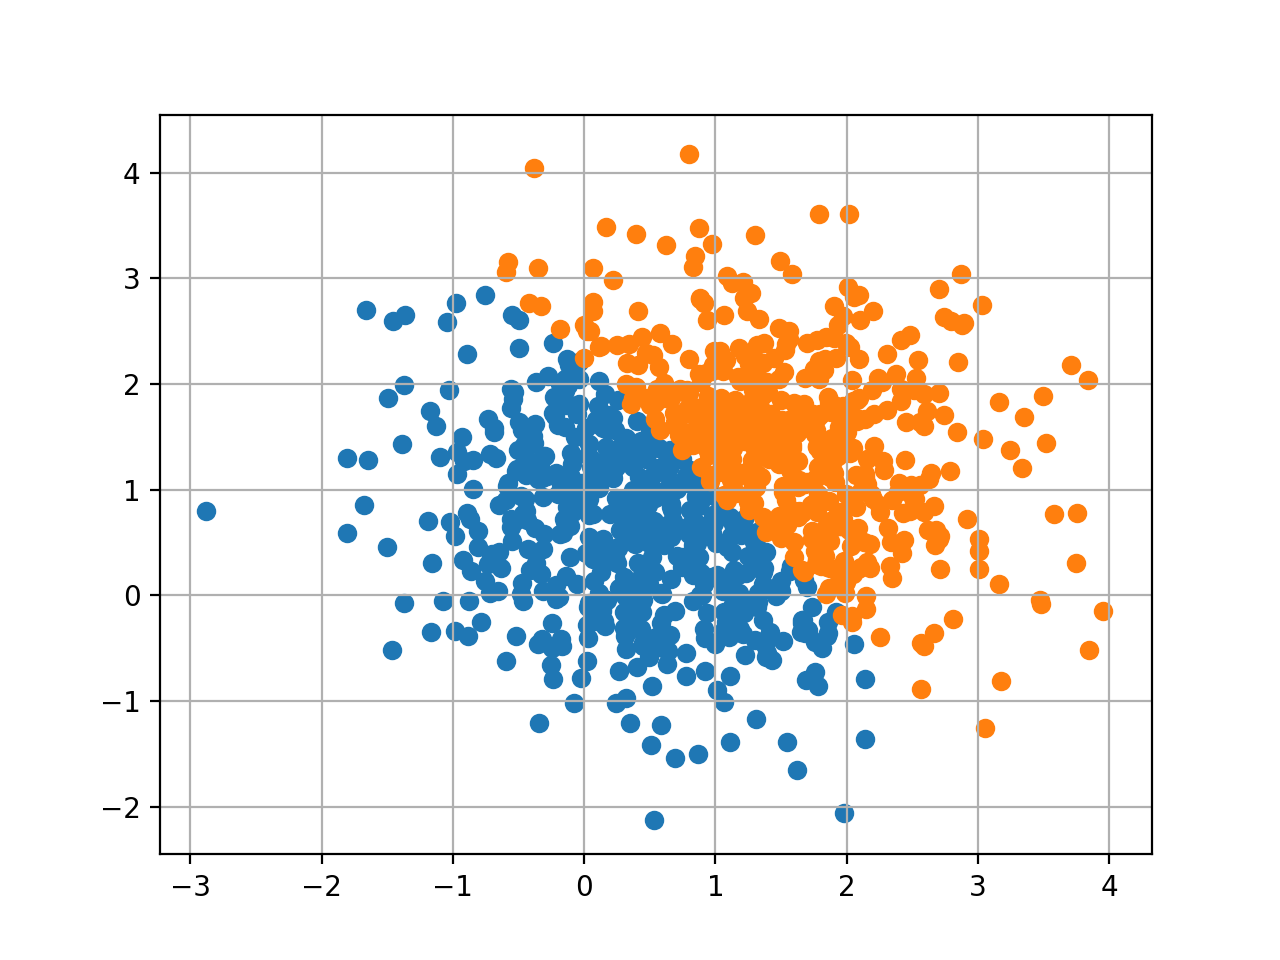

In [7]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==0]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==0]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [8]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)
# tensor_x = torch.stack([torch.Tensor(i) for i in zip(samples_x, samples_y)]) # transform to torch tensors
# tensor_y = torch.stack([torch.Tensor(i) for i in samples_labels])

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=256) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [9]:
# Define a specific Finite Gaussian Neural Network

class Classic_MNIST_Net(nn.Module):
    def __init__(self):
        super(Classic_MNIST_Net, self).__init__()
        self.l1 = nn.Linear(num_dim,2)

    def forward(self, x):
        x = self.l1(x)

        return x

In [10]:
# Initialize the network
model = Classic_MNIST_Net().to(device)

In [11]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weight.size()) 
print(model.l1.bias.size()) 


# check weights before training
print("l1")
print(model.l1.weight.view(-1).cpu().detach().numpy())
print(model.l1.bias.view(-1).cpu().detach().numpy())


Classic_MNIST_Net(
  (l1): Linear(in_features=2, out_features=2, bias=True)
)
[torch.Size([2, 2]), torch.Size([2])]
Training? True
l1
torch.Size([2, 2])
torch.Size([2])
l1
[ 0.52879566 -0.30404836  0.083507   -0.10127002]
[ 0.27661008 -0.28520307]


In [12]:
def train(model, device, train_loader, optimizer, epoch):
    
    # values to return
    weights =  []
    biases = []
    weights.append(list(model.l1.weight.view(-1).cpu().detach().numpy()))
    biases.append(list(model.l1.bias.view(-1).cpu().detach().numpy()))
    losses = th.AverageMeter()
    correct = 0
    
    # set model to trainable mode
    model.train()
    # load a batch
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(data,target)
        # load batch data, targets to device
        data, target = data.to(device), target.to(device)
        # reset optimizer gradients
        optimizer.zero_grad()
        # compute predictions
        output = model(data)
#         print(output)
#         print(target)
        # compute loss
        loss = F.cross_entropy(output, target.long())
        # print(loss)
        
        # update rolling average loss
        losses.update(loss.item(), data.size(0) )
        # update predictions
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.long().view_as(pred)).sum().item()        
        
        # propagate gradients and store them
        loss.backward()
#         print("max grad centers:", torch.max(model.l1.centers.grad) )
#         print("max grad sigs:", torch.max(model.l1.sigs.grad) )

        # apply stored gradients to parameters
        optimizer.step()
        
        # print batch stats
#         if batch_idx % (num_samples/5) == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#             print("batch:", batch_idx, " Loss", losses.avg)
    
        weights.append(list(model.l1.weight.view(-1).cpu().detach().numpy()))
        biases.append(list(model.l1.bias.view(-1).cpu().detach().numpy()))
        
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        losses.avg, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

    return(losses.avg, 100. * correct / len(train_loader.dataset), weights, biases)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target.long())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.long().view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return (test_loss, 100. * correct / len(test_loader.dataset))

In [13]:
# train the model 

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5)

# values to observes
weights_hist =  []
biases_hist = []

test_acc_hist = []
test_loss_hist = []
train_acc_hist = []
train_loss_hist = []

In [14]:
for epoch in range(1, 500):
    print("Epoch:", epoch)
    train_loss, train_acc, weights, biases = train(model, device, my_dataloader, optimizer, epoch)
    weights_hist+=weights
    biases_hist += biases
    
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)
    
    test_loss, test_acc = test(model, device, my_test_dataloader)
    test_acc_hist.append(test_acc)
    test_loss_hist.append(test_loss)

Epoch: 1
Train set: Average loss: 0.8827, Accuracy: 370/800 (46%)
Test set: Average loss: 0.7612, Accuracy: 109/200 (54%)
Epoch: 2
Train set: Average loss: 0.8111, Accuracy: 378/800 (47%)
Test set: Average loss: 0.7095, Accuracy: 110/200 (55%)
Epoch: 3
Train set: Average loss: 0.7435, Accuracy: 387/800 (48%)
Test set: Average loss: 0.6700, Accuracy: 118/200 (59%)
Epoch: 4
Train set: Average loss: 0.6911, Accuracy: 429/800 (54%)
Test set: Average loss: 0.6409, Accuracy: 133/200 (66%)
Epoch: 5
Train set: Average loss: 0.6511, Accuracy: 502/800 (63%)
Test set: Average loss: 0.6194, Accuracy: 140/200 (70%)
Epoch: 6
Train set: Average loss: 0.6205, Accuracy: 560/800 (70%)
Test set: Average loss: 0.6033, Accuracy: 139/200 (70%)
Epoch: 7
Train set: Average loss: 0.5968, Accuracy: 590/800 (74%)
Test set: Average loss: 0.5911, Accuracy: 143/200 (72%)
Epoch: 8
Train set: Average loss: 0.5781, Accuracy: 606/800 (76%)
Test set: Average loss: 0.5815, Accuracy: 146/200 (73%)
Epoch: 9
Train set: Aver

Test set: Average loss: 0.4194, Accuracy: 166/200 (83%)
Epoch: 71
Train set: Average loss: 0.3649, Accuracy: 695/800 (87%)
Test set: Average loss: 0.4178, Accuracy: 166/200 (83%)
Epoch: 72
Train set: Average loss: 0.3634, Accuracy: 695/800 (87%)
Test set: Average loss: 0.4163, Accuracy: 166/200 (83%)
Epoch: 73
Train set: Average loss: 0.3620, Accuracy: 696/800 (87%)
Test set: Average loss: 0.4149, Accuracy: 166/200 (83%)
Epoch: 74
Train set: Average loss: 0.3606, Accuracy: 698/800 (87%)
Test set: Average loss: 0.4134, Accuracy: 166/200 (83%)
Epoch: 75
Train set: Average loss: 0.3592, Accuracy: 698/800 (87%)
Test set: Average loss: 0.4119, Accuracy: 166/200 (83%)
Epoch: 76
Train set: Average loss: 0.3578, Accuracy: 699/800 (87%)
Test set: Average loss: 0.4105, Accuracy: 166/200 (83%)
Epoch: 77
Train set: Average loss: 0.3565, Accuracy: 702/800 (88%)
Test set: Average loss: 0.4091, Accuracy: 166/200 (83%)
Epoch: 78
Train set: Average loss: 0.3552, Accuracy: 705/800 (88%)
Test set: Averag

Test set: Average loss: 0.3435, Accuracy: 174/200 (87%)
Epoch: 140
Train set: Average loss: 0.2948, Accuracy: 733/800 (92%)
Test set: Average loss: 0.3427, Accuracy: 175/200 (88%)
Epoch: 141
Train set: Average loss: 0.2941, Accuracy: 733/800 (92%)
Test set: Average loss: 0.3419, Accuracy: 175/200 (88%)
Epoch: 142
Train set: Average loss: 0.2934, Accuracy: 733/800 (92%)
Test set: Average loss: 0.3411, Accuracy: 175/200 (88%)
Epoch: 143
Train set: Average loss: 0.2927, Accuracy: 734/800 (92%)
Test set: Average loss: 0.3403, Accuracy: 175/200 (88%)
Epoch: 144
Train set: Average loss: 0.2920, Accuracy: 734/800 (92%)
Test set: Average loss: 0.3395, Accuracy: 175/200 (88%)
Epoch: 145
Train set: Average loss: 0.2913, Accuracy: 734/800 (92%)
Test set: Average loss: 0.3388, Accuracy: 175/200 (88%)
Epoch: 146
Train set: Average loss: 0.2906, Accuracy: 734/800 (92%)
Test set: Average loss: 0.3380, Accuracy: 175/200 (88%)
Epoch: 147
Train set: Average loss: 0.2900, Accuracy: 735/800 (92%)
Test set

Test set: Average loss: 0.3003, Accuracy: 178/200 (89%)
Epoch: 208
Train set: Average loss: 0.2564, Accuracy: 751/800 (94%)
Test set: Average loss: 0.2998, Accuracy: 178/200 (89%)
Epoch: 209
Train set: Average loss: 0.2560, Accuracy: 752/800 (94%)
Test set: Average loss: 0.2993, Accuracy: 178/200 (89%)
Epoch: 210
Train set: Average loss: 0.2555, Accuracy: 752/800 (94%)
Test set: Average loss: 0.2988, Accuracy: 178/200 (89%)
Epoch: 211
Train set: Average loss: 0.2551, Accuracy: 753/800 (94%)
Test set: Average loss: 0.2983, Accuracy: 179/200 (90%)
Epoch: 212
Train set: Average loss: 0.2546, Accuracy: 753/800 (94%)
Test set: Average loss: 0.2978, Accuracy: 180/200 (90%)
Epoch: 213
Train set: Average loss: 0.2542, Accuracy: 753/800 (94%)
Test set: Average loss: 0.2973, Accuracy: 180/200 (90%)
Epoch: 214
Train set: Average loss: 0.2538, Accuracy: 753/800 (94%)
Test set: Average loss: 0.2968, Accuracy: 180/200 (90%)
Epoch: 215
Train set: Average loss: 0.2533, Accuracy: 753/800 (94%)
Test set

Test set: Average loss: 0.2712, Accuracy: 184/200 (92%)
Epoch: 277
Train set: Average loss: 0.2308, Accuracy: 762/800 (95%)
Test set: Average loss: 0.2708, Accuracy: 185/200 (92%)
Epoch: 278
Train set: Average loss: 0.2305, Accuracy: 763/800 (95%)
Test set: Average loss: 0.2705, Accuracy: 185/200 (92%)
Epoch: 279
Train set: Average loss: 0.2302, Accuracy: 763/800 (95%)
Test set: Average loss: 0.2701, Accuracy: 185/200 (92%)
Epoch: 280
Train set: Average loss: 0.2299, Accuracy: 763/800 (95%)
Test set: Average loss: 0.2698, Accuracy: 185/200 (92%)
Epoch: 281
Train set: Average loss: 0.2296, Accuracy: 763/800 (95%)
Test set: Average loss: 0.2694, Accuracy: 185/200 (92%)
Epoch: 282
Train set: Average loss: 0.2293, Accuracy: 763/800 (95%)
Test set: Average loss: 0.2691, Accuracy: 185/200 (92%)
Epoch: 283
Train set: Average loss: 0.2290, Accuracy: 763/800 (95%)
Test set: Average loss: 0.2687, Accuracy: 185/200 (92%)
Epoch: 284
Train set: Average loss: 0.2287, Accuracy: 763/800 (95%)
Test set

Test set: Average loss: 0.2503, Accuracy: 188/200 (94%)
Epoch: 345
Train set: Average loss: 0.2127, Accuracy: 767/800 (96%)
Test set: Average loss: 0.2501, Accuracy: 188/200 (94%)
Epoch: 346
Train set: Average loss: 0.2125, Accuracy: 767/800 (96%)
Test set: Average loss: 0.2498, Accuracy: 188/200 (94%)
Epoch: 347
Train set: Average loss: 0.2123, Accuracy: 767/800 (96%)
Test set: Average loss: 0.2495, Accuracy: 188/200 (94%)
Epoch: 348
Train set: Average loss: 0.2121, Accuracy: 767/800 (96%)
Test set: Average loss: 0.2493, Accuracy: 188/200 (94%)
Epoch: 349
Train set: Average loss: 0.2118, Accuracy: 767/800 (96%)
Test set: Average loss: 0.2490, Accuracy: 188/200 (94%)
Epoch: 350
Train set: Average loss: 0.2116, Accuracy: 767/800 (96%)
Test set: Average loss: 0.2488, Accuracy: 188/200 (94%)
Epoch: 351
Train set: Average loss: 0.2114, Accuracy: 767/800 (96%)
Test set: Average loss: 0.2485, Accuracy: 188/200 (94%)
Epoch: 352
Train set: Average loss: 0.2112, Accuracy: 767/800 (96%)
Test set

Test set: Average loss: 0.2341, Accuracy: 190/200 (95%)
Epoch: 414
Train set: Average loss: 0.1987, Accuracy: 773/800 (97%)
Test set: Average loss: 0.2339, Accuracy: 190/200 (95%)
Epoch: 415
Train set: Average loss: 0.1985, Accuracy: 773/800 (97%)
Test set: Average loss: 0.2337, Accuracy: 190/200 (95%)
Epoch: 416
Train set: Average loss: 0.1984, Accuracy: 773/800 (97%)
Test set: Average loss: 0.2335, Accuracy: 190/200 (95%)
Epoch: 417
Train set: Average loss: 0.1982, Accuracy: 773/800 (97%)
Test set: Average loss: 0.2333, Accuracy: 190/200 (95%)
Epoch: 418
Train set: Average loss: 0.1980, Accuracy: 773/800 (97%)
Test set: Average loss: 0.2331, Accuracy: 190/200 (95%)
Epoch: 419
Train set: Average loss: 0.1978, Accuracy: 773/800 (97%)
Test set: Average loss: 0.2329, Accuracy: 190/200 (95%)
Epoch: 420
Train set: Average loss: 0.1977, Accuracy: 773/800 (97%)
Test set: Average loss: 0.2327, Accuracy: 190/200 (95%)
Epoch: 421
Train set: Average loss: 0.1975, Accuracy: 775/800 (97%)
Test set

Test set: Average loss: 0.2213, Accuracy: 191/200 (96%)
Epoch: 482
Train set: Average loss: 0.1877, Accuracy: 776/800 (97%)
Test set: Average loss: 0.2211, Accuracy: 191/200 (96%)
Epoch: 483
Train set: Average loss: 0.1876, Accuracy: 776/800 (97%)
Test set: Average loss: 0.2210, Accuracy: 191/200 (96%)
Epoch: 484
Train set: Average loss: 0.1874, Accuracy: 776/800 (97%)
Test set: Average loss: 0.2208, Accuracy: 191/200 (96%)
Epoch: 485
Train set: Average loss: 0.1873, Accuracy: 776/800 (97%)
Test set: Average loss: 0.2206, Accuracy: 191/200 (96%)
Epoch: 486
Train set: Average loss: 0.1872, Accuracy: 776/800 (97%)
Test set: Average loss: 0.2205, Accuracy: 191/200 (96%)
Epoch: 487
Train set: Average loss: 0.1870, Accuracy: 776/800 (97%)
Test set: Average loss: 0.2203, Accuracy: 191/200 (96%)
Epoch: 488
Train set: Average loss: 0.1869, Accuracy: 776/800 (97%)
Test set: Average loss: 0.2201, Accuracy: 191/200 (96%)
Epoch: 489
Train set: Average loss: 0.1867, Accuracy: 776/800 (97%)
Test set

In [20]:
# check weights after training
print("l1")
print(model.l1.weight.view(-1).cpu().detach().numpy())
print(model.l1.bias.view(-1).cpu().detach().numpy())

l1
[-0.91345793 -1.1667265   1.5257611   0.76140994]
[ 2.0545228 -2.0631144]


In [16]:
# l1
# [-0.53201663 -0.65015894]
# [-1. -1.]
# [2.]

<IPython.core.display.Javascript object>


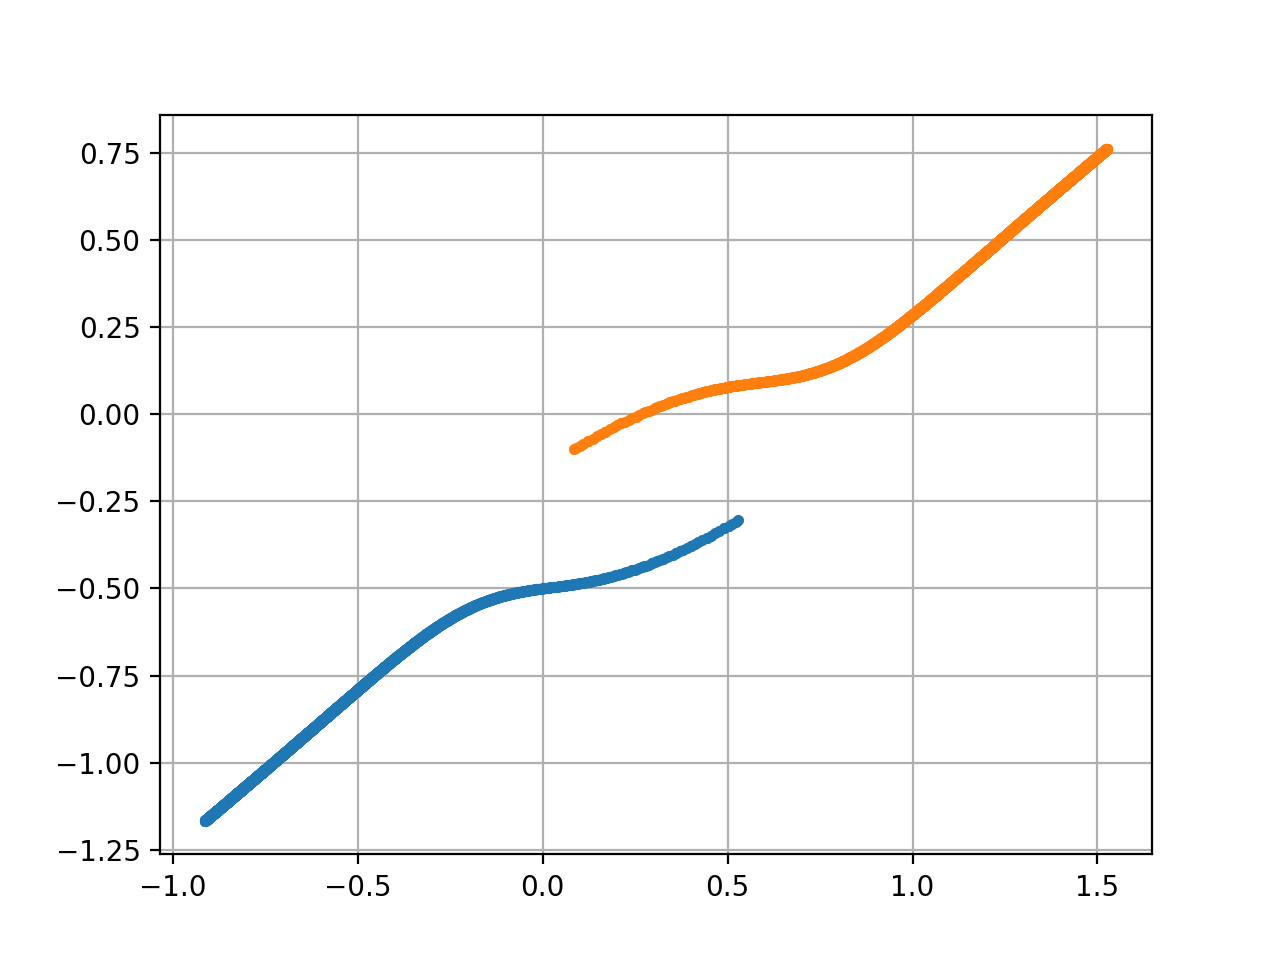

<IPython.core.display.Javascript object>


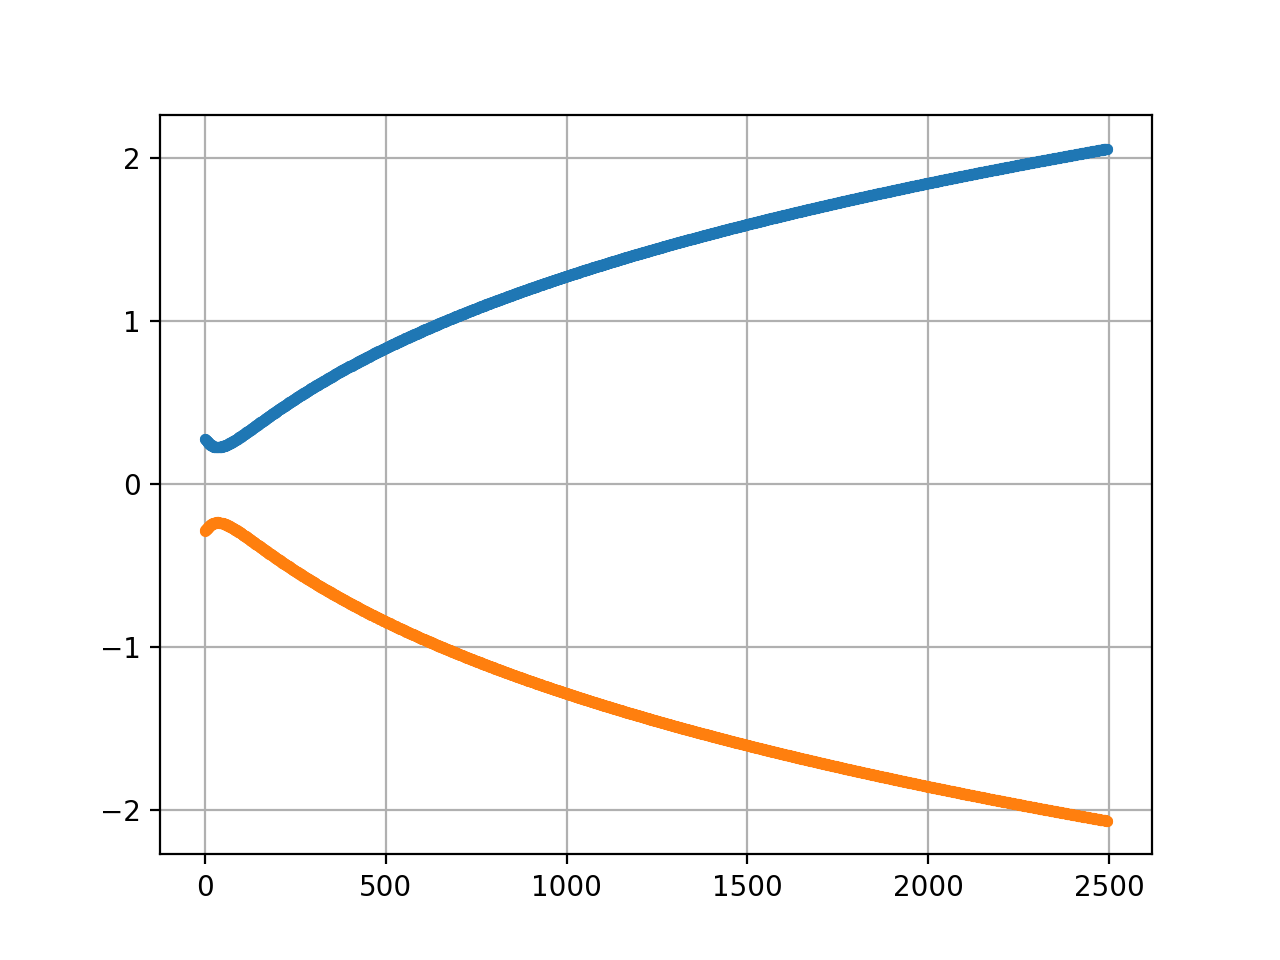

In [19]:
# weights (only makes sense to visualize in 2d problem)
XYs = zip(*weights_hist)
for idx,_ in enumerate(XYs[::2]):
    plt.plot(XYs[2*idx],XYs[1+2*idx], marker='.', linestyle=' ')
plt.grid()
plt.show()

# biases
x1, x2  = zip(*biases_hist)
plt.plot(x1, marker='.', linestyle=' ')
plt.plot(x2, marker='.', linestyle=' ')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


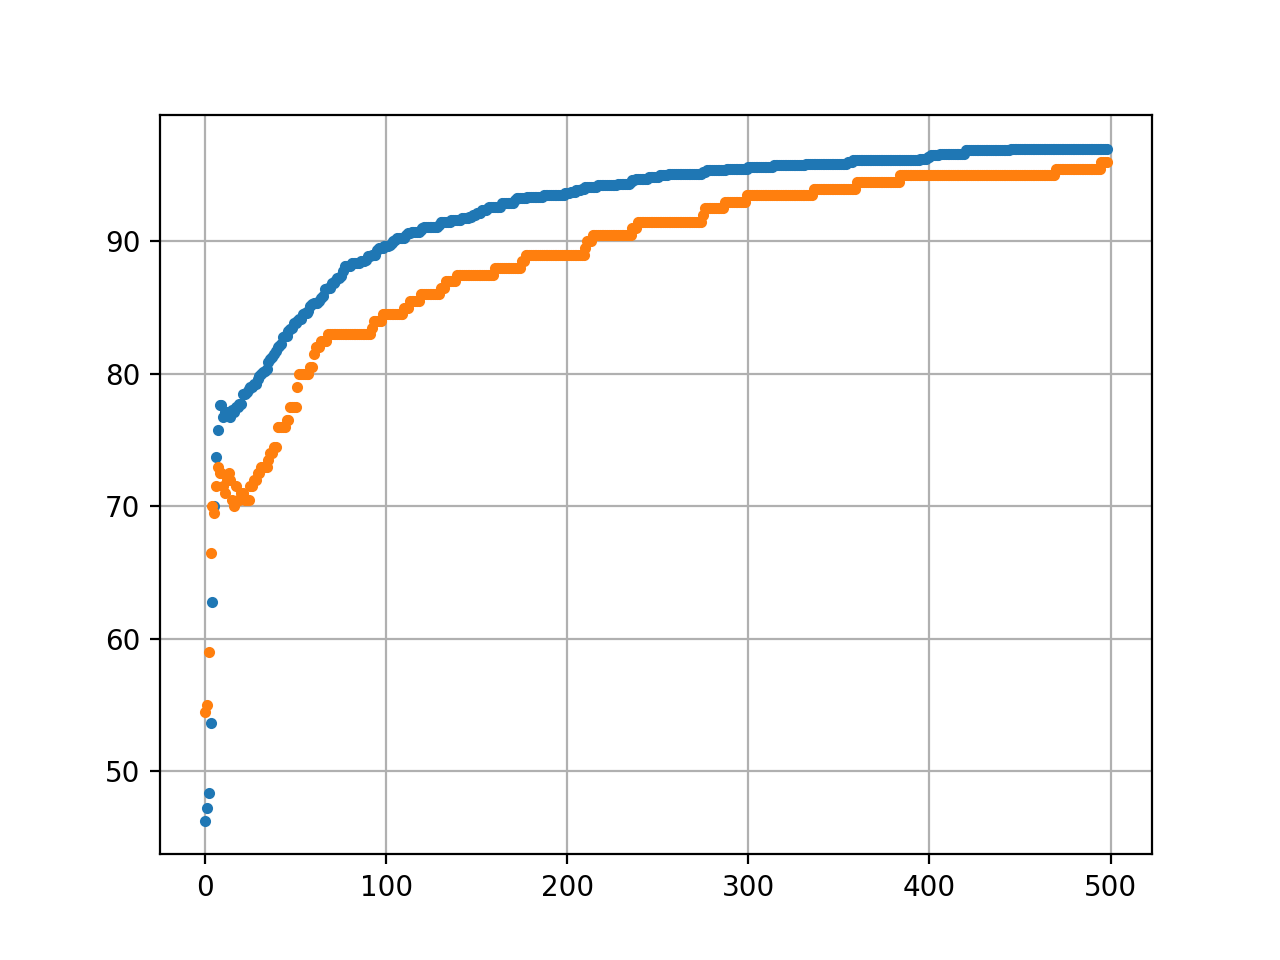

<IPython.core.display.Javascript object>


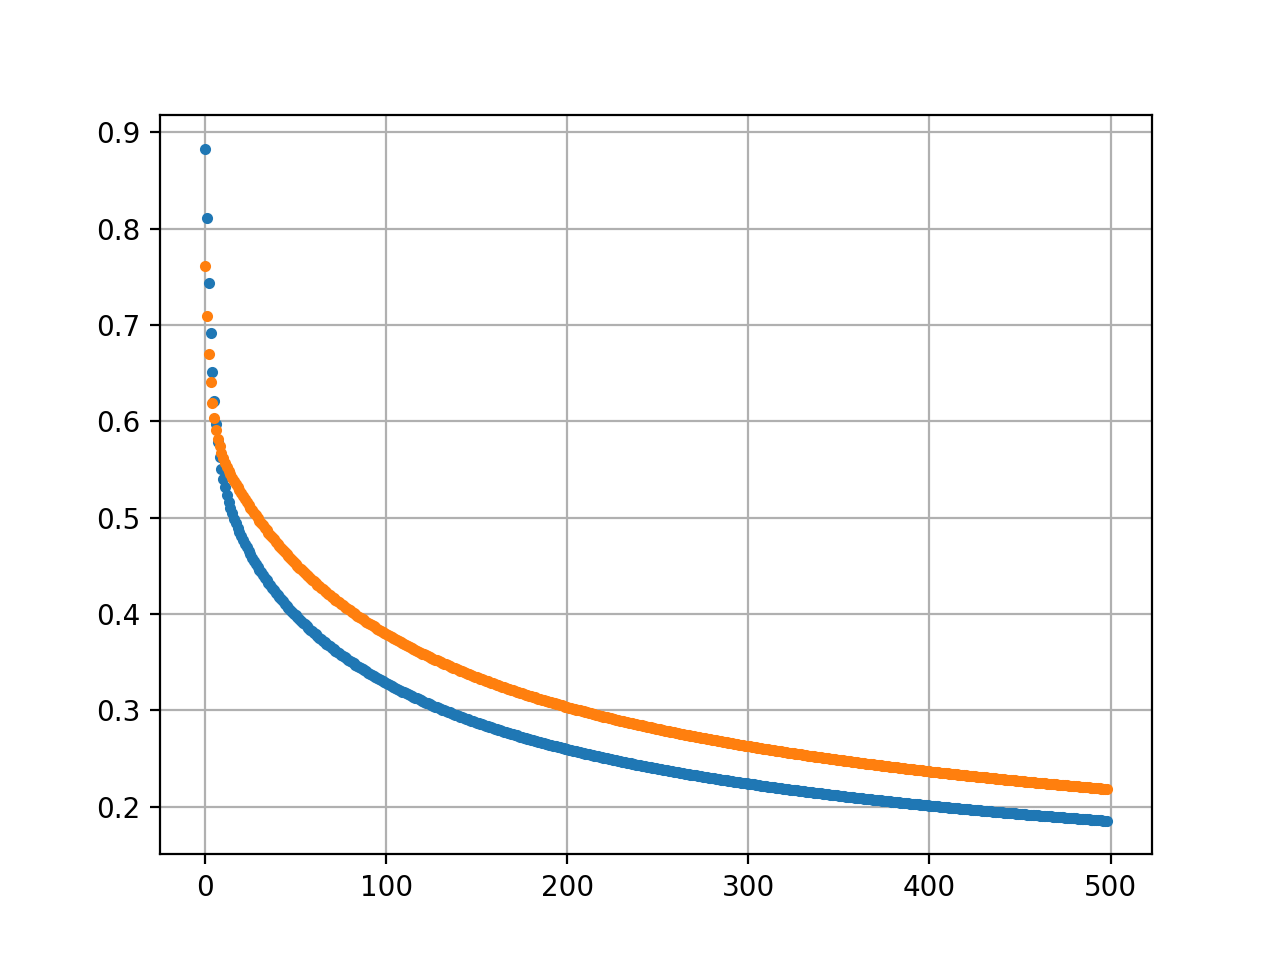

In [18]:
# acc and loss hist
plt.plot(train_acc_hist, marker='.', linestyle=' ')
plt.plot(test_acc_hist, marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(train_loss_hist, marker='.', linestyle=' ')
plt.plot(test_loss_hist, marker='.', linestyle=' ')
plt.grid()
plt.show()